In [15]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from src.huge_dataset_project.InputLoader import InputFile
from src.huge_dataset_project.PickLoader import PickFile
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model import HomogeneousSoundModel

/home/plerolland/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [6]:
picks = PickFile("../../huge_dataset_project/swarm2.pick")
input = InputFile("../../huge_dataset_project/Swarm2_data.input")
stations = StationsCatalog("/home/plerolland/Bureau/dataset.yaml").filter_out_undated().filter_out_unlocated()

acoustic_homogeneous = HomogeneousSoundModel(sound_speed=1480)

In [9]:
errors = []
for pick in tqdm(picks.picks):
    h_letters = pick.hydrophones
    h_names = [input.hydrophone_names[list(input.hydrophone_letters).index(h_letter)] for h_letter in h_letters]
    h_names = [h_name+"-bot" if h_name=="SWAMS" else h_name for h_name in h_names]
    
    available_s = [stations.by_date(pick.detection_times[i]).by_names(h_names[i])[0] for i in range(len(h_names))]
    
    positions = [s.get_pos() for s in available_s]
    res = acoustic_homogeneous.localize_common_source(positions, pick.detection_times)
    est_pos = res.x[1:]
    est_time = np.min(pick.detection_times) + datetime.timedelta(seconds=res.x[0])
    errors.append((est_pos[0]-pick.est_source_pos[0], est_pos[1]-pick.est_source_pos[1], est_time-pick.est_source_time))
    
errors = np.array(errors)

100%|██████████| 4927/4927 [03:42<00:00, 22.13it/s]


0.05188065


(array([ 569., 2032.,  225.,   46.,  227.,  481.,  499.,  398.,  180.,
          23.]),
 array([0.0003785 , 0.01312513, 0.02587176, 0.03861839, 0.05136501,
        0.06411164, 0.07685827, 0.0896049 , 0.10235152, 0.11509816,
        0.12784478]),
 <BarContainer object of 10 artists>)

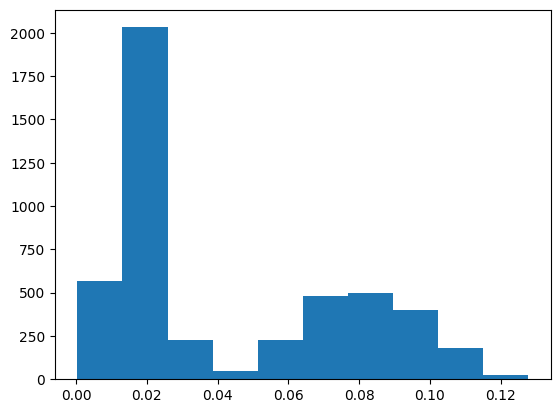

In [36]:
to_plot = np.sqrt(np.square(errors[:,0].astype(np.float32)) + np.square(errors[:,1].astype(np.float32)))
print(np.mean(to_plot))

to_plot = np.delete(to_plot, np.abs(to_plot) > np.quantile(np.abs(to_plot), 0.95))
plt.hist(to_plot, bins=10)